In [3]:
import pandas as pd
import numpy as np
# General Integration Functions
# ______________________________________________________________________________________________________________________
def import_raw_dynamix_data(data_path, map_path, extra=0):
    raw_data = parse_raw_dynamix_data(data_path)

    map_df = pd.read_csv(map_path, skiprows=1, header=None, sep='\t')
    # delete the first column
    map_df = map_df.drop(columns=[0])

    # map_df = map_df.drop(columns=['Unnamed: 0'])

    drugs, positions = format_data(raw_data)
    drugs, positions, drug_names = map_raw_data(drugs, positions, map_df, extra=extra)
    # save this data to a csv
    
    validate_sizes(drugs, positions, drug_names)

    return merge_raw_data(drugs, drug_names, positions)

# Data Integration/Importing Functions
# ______________________________________________________________________________________________________________________

def parse_raw_dynamix_data(the_file_path):
    """
    Parses Raw Data From the Dynamix Machine from 2021 Onwards and returns a DataFrame.

    Args:
        the_file_path (str): The path to the file containing the raw Dynamix data.

    Returns:
        pandas.DataFrame: The parsed data as a DataFrame.

    """
    with open(the_file_path, 'r') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]

    instrument = lines[0].split('\t')[0]
    date = lines[1].split('\t')[0]
    time = lines[1].split('\t')[1]
    
    lines = lines[2:]

    unprocessed = [line.split('\t') for line in lines]
    transposed = transpose_raw_data(unprocessed)
    grouped_data = [transposed[i:i+4] for i in range(0, len(transposed), 4)]

    # Flatten grouped_data for DataFrame construction
    flattened_data = []
    for group in grouped_data:
        for row in group:
            flattened_data.append(row)

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    # Adding instrument, date, and time as additional columns if needed
    # df['Instrument'] = instrument
    # df['Date'] = date
    # df['Time'] = time

    validate_raw_data(df)

    return df


# Processing Functions
# ______________________________________________________________________________________________________________________

# import lowess
from statsmodels.nonparametric.smoothers_lowess import lowess
def format_data(the_dynamix_data, splitting_by = 4):
    drugs = []
    positions = []
    errors = 0
    # print("length", len(the_dynamix_data))
    for i in range(0, len(the_dynamix_data), splitting_by):
        try:
            # print(i, "/",len(the_dynamix_data))
            df = pd.DataFrame()
            data = the_dynamix_data[i:i+splitting_by]
            # get the data from the first row
            df['raw_time'] = data.iloc[0]
            # convert to hours
            try:
                # insert a column for hours
                df['hours'] = pd.to_numeric(df['raw_time'], errors='coerce').round(1)
                df['hours'] = round(df['hours'] /3600,2)
            except:
                pass

            df['raw_o2'] = data.iloc[1]
            # normalize 
            df['noise'] = data.iloc[2]

            metadata = df.iloc[0]
            # from metadata, get the drug name and position
            position = str(metadata).split('@')[1].split('noise')[0]
            
            # get everything in the () and remove the ()
            position = str(metadata).split('(')[1].split(')')[0]
            df = df.iloc[1:]
            string_noise = df['noise'].str.split(':', n=0, expand=True)

            # convert to float
            noise0 = string_noise[0].astype(float)
            noise1 = string_noise[1].astype(float)
            ratio = noise0 / noise1
            # remove first row from df

            df['noise'] = ratio
            # any row where noise is less than 1, replace intensity with null
            df.loc[df['noise'] < 0.5, 'raw_o2'] = np.nan
            # any value of intensity that is less than -10 replace with null
            # convert intensity to float
            df['raw_o2'] = df['raw_o2'].astype(float)
            # lowess 
            try: 
                # fill nan values with 0
                temp_df = df.fillna(0)
                smoothed = lowess(temp_df['raw_o2'], temp_df.index, frac=0.1)
                df['smoothed'] = smoothed[:, 1]
            except Exception as e:
                print(e);
                
            df.loc[df['raw_o2'] < 0, 'raw_o2'] = np.nan
            # remove noise column
            # df = df.drop(columns=['noise'])
            drugs.append(df)   
            positions.append(position)

        except Exception as e:
            # print("Skipping over an error. Please ensure positions and drugs are the same length.")
            # add a null value to drugs and positions
            drugs.append(None)
            positions.append(None)
            errors += 1
            # print(e)
    if errors > 0:
        print(f"Number of errors: {errors}")
    return drugs, positions

def transpose_raw_data(lists):
    """
    Transposes a list of lists from the raw data, to make it easier to match the drug names with the positions.

    Args:
        lists (list): The list of lists to be transposed.

    Returns:
        list: The transposed list of lists.
    """
    # Find the length of the longest list
    max_length = max(len(single_list) for single_list in lists)
    
    # Transpose the list of lists
    transposed = []
    for i in range(max_length):
        transposed_row = []
        for single_list in lists:
            # Add the element if it exists, otherwise add None
            transposed_row.append(single_list[i] if i < len(single_list) else None)
        transposed.append(transposed_row)
    
    return transposed

def map_raw_data(the_drugs, the_positions, the_map_df, extra=0):
    """
    Maps raw data by matching drug positions with corresponding drug names on a map.

    Args:
        the_drugs (list): List of drugs.
        the_positions (list): List of positions.
        the_map_df (pandas.DataFrame): DataFrame representing the map.
        extra (int): Extra value to adjust the position.

    Returns:
        tuple: A tuple containing three lists - drugs, positions, and drug_names.
            - drugs (list): List of drugs.
            - positions (list): List of positions.
            - drug_names (list): List of corresponding drug names.

    Raises:
        None.

    """
    drug_names = []
    positions = []
    drugs = []
    index = 0
    errors = 0
    all_ys = []
    for position in the_positions:
        try:
            x = int(position.split('/')[0]) - 1
            y = int(position.split('/')[1]) - 1 - extra
            all_ys.append(y)

                

            # get the drug name from the map
            drug = the_map_df.iloc[y, x]
            positions.append([y, x])
            drug_names.append(drug)
            drugs.append(the_drugs[index])
            index += 1
        except Exception as e:
            errors += 1
            index += 1
    if errors > 0:
        print(f"Number of errors: {errors}")

    return drugs, positions, drug_names

def merge_raw_data(the_drugs, the_drug_names, the_positions):
    """
    Merge the drug names with the drugs.

    Args:
        the_drugs (list): A list of dictionaries representing drug data.
        the_drug_names (list): A list of drug names.
        the_positions (list): A list of positions.

    Returns:
        list: A list of dictionaries representing merged drug data.
    """
    for i in range(0, len(the_drugs)):
        the_drugs[i]['Raw Name'] = the_drug_names[i]
        the_drugs[i]['Position'] = str(the_positions[i])
        the_drugs[i]['Name'] = the_drugs[i]['Raw Name'].str.split('_| |%%', n=0, expand=True)[0]
        # the_drugs[i]['Concentration'] = the_drugs[i]['Raw Name'].str.split('_| |%%', n=0, expand=True)[1]
        # the_drugs[i]['Just Concentration'] = the_drugs[i]['Concentration'].str.split('uM|%M', n=0, expand=True)[0]
    return the_drugs

# Validation Functions
# ______________________________________________________________________________________________________________________

def validate_raw_data(the_dynamix_data, splitting_by=4):
    """
    Validates the raw data by checking if the number of rows in the dynamix data is divisible by the splitting factor.

    Parameters:
    the_dynamix_data (list): The raw data to be validated.
    splitting_by (int): The factor by which the number of rows should be divisible. Default is 4.

    Returns:
    bool: True if the number of rows is divisible by the splitting factor, False otherwise.
    """
    if len(the_dynamix_data) % splitting_by != 0:
        print("Warning: The number of rows in the raw dynamix data are not divisible by 4. Is this perhaps an old file?")
        return False
    else:
        print("Validating: Raw Data Healthy")
        return True

def validate_transposition(the_positions, the_drugs):
    """
    Validates the transposition of positions and drugs.

    Args:
        the_positions (list): A list of positions.
        the_drugs (list): A list of drugs.

    Returns:
        bool: True if the positions and drugs are of the same length, False otherwise.
    """
    # check they are the same length
    if len(the_positions) != len(the_drugs):
        print(f'Warning: Positions and drugs are not the same length. This could be due to a mismatch of maps. Positions:{len(the_positions)} Drugs:{len(the_drugs)}')
        return False
    else:
        print("Validating: Tranposition Healthy")
        return True
 
def validate_sizes(drugs, positions, drug_names):
    """
    Validates the sizes of the drugs, positions, and drug_names lists.

    Parameters:
    drugs (list): A list of drugs.
    positions (list): A list of positions.
    drug_names (list): A list of drug names.

    Returns:
    bool: True if the sizes of the lists are equal, False otherwise.
    """
    if len(drugs) != len(positions) and  len(drugs) != len(drug_names):
        print(f'Warning: Drugs, positions, and drug names are not the same length, Drugs:{len(drugs)} Positions:{len(positions)} Drug Names:{len(drug_names)}')
        return False
    else:
        print("Validating: Sizes Healthy")
        return True

def filter_drug_groups(drugs_by_name):
    # plot each drug group
    for name in drugs_by_name:
        # if name == 'valproate' or name == 'ace' or name == 'stavadone' or name == 'rosiglitazone' or name == 'troglitarazone' or name == 'tunicamycin' or name == 'thapsigargin':
        #     continue
        drug_group = drugs_by_name[name]
        drug_group = filter_drug_group(drug_group)
        drugs_by_name[name] = drug_group
    return drugs_by_name

def filter_drug_group(drug_group):
    try:
        drug_name = drug_group[0]['Name'].iloc[0]
        # create two plots, one for the raw data and one for the processed data

        
        # go through and get a list of the unique concentrations to create a color map
        concentrations = []
        for i in range(0, len(drug_group)):
            df = drug_group[i]
            concentration = df['Just Concentration'].iloc[0]
            # convert to float
            concentration = float(concentration)
            concentrations.append(concentration)
        concentrations = list(set(concentrations))
        concentrations.sort()


        highest_concentration_dfs = []
        for i in range(0, len(drug_group)):
            df = drug_group[i]
            # drop NaN values
            df = df.dropna()
            concentration = df['Just Concentration'].iloc[0]
            # convert to float
            concentration = float(concentration)
            if concentration == max(concentrations):
                highest_concentration_dfs.append(df)
        max_values = []
        for df in highest_concentration_dfs:
            max_values.append(df['o2'].mean())
    except:
        return drug_group

    # If we are pre-emptively removing outlier concentrations
    # average_max = sum(max_values)/len(max_values)
    # new_drug_group = []
    # for i in range(0, len(drug_group)):
    #     try:
    #         df = drug_group[i]
    #         name = df['Name'].iloc[0]
    #         concentration = df['Just Concentration'].iloc[0]
    #         concentration = float(concentration)

    #         # is it a high concentration?
    #         mid_concentration = concentrations[len(concentrations)//2]
    #         if df['o2'].mean() > average_max*0.7 and concentration < mid_concentration:
    #             print("removing", name, concentration)
    #             continue
    #         # if there are no o2 values, remove it
    #         if df['o2'].mean() == 0:
    #             continue
    #         new_drug_group.append(df)
    #     except:
    #         continue
    
    return drug_group

def group_concentrations(processed_drugs_array):
    # group the drugss by name
    # create a dictionary where the key is the name and the value is the dataframe
    drugs_by_name = {}
    for i in range(0, len(processed_drugs_array)-1):
        df = processed_drugs_array[i]
        name = df['Name'].iloc[0]
        if name in drugs_by_name:
            drugs_by_name[name].append(df)
        else:
            drugs_by_name[name] = [df]
    return drugs_by_name

Validating: Raw Data Healthy
Validating: Sizes Healthy


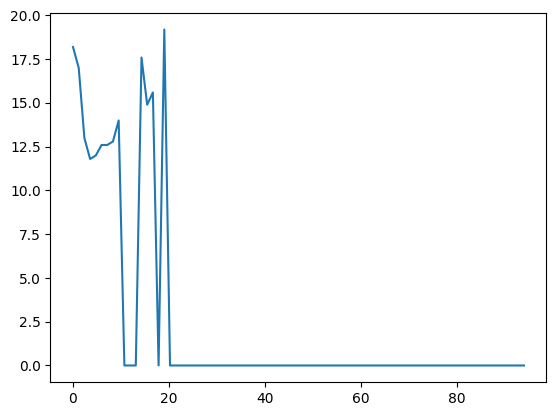

In [10]:
path='3152019190452GBM1919_AOD7.txt'
name = path.split('.txt')[0]
all_drug_all_concentrations1 = import_raw_dynamix_data(path, 'Primary_384Plate3Rep.csv', 0)
import matplotlib.pyplot as plt
plt.plot(all_drug_all_concentrations1[5]['hours'], all_drug_all_concentrations1[5]['smoothed'], label='smoothed')

# concat into one dataframe
all_drug_all_concentrations = pd.concat(all_drug_all_concentrations1)
# save to csv
all_drug_all_concentrations.to_csv('Yuval/' + name + '.csv')
